In [1]:
import math
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt  # for plotting stuff
import pandas as pd
from collections import defaultdict
from sklearn import preprocessing
from functools import partial
import multiprocessing as mp
from LogisticRegression import LogisticRegression

import os, sys

path = os.getcwd()
DIR_DATA = path + '/datasets/'

In [2]:
def load_compas_data(DIR_DATA):
    FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count","c_charge_degree"]  # features to be used for classification
    CONT_VARIABLES = ["priors_count"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "two_year_recid"  # the decision variable
    SENSITIVE_ATTRS = ["race"]

    COMPAS_INPUT_FILE = DIR_DATA + "compas/compas-scores-two-years.csv"
    print('Loading COMPAS dataset...')
    
    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df = df.dropna(subset=["days_b_screening_arrest"])  # dropping missing vals

    # convert to np array
    data = df.to_dict('list')
    for k in data.keys():
        data[k] = np.array(data[k])

    """ Filtering the data """

    # These filters are the same as propublica (refer to https://github.com/propublica/compas-analysis)
    # If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
    idx = np.logical_and(data["days_b_screening_arrest"] <= 30, data["days_b_screening_arrest"] >= -30)

    # We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
    idx = np.logical_and(idx, data["is_recid"] != -1)

    # In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
    idx = np.logical_and(idx, data["c_charge_degree"] != "O")  # F: felony, M: misconduct

    # We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
    idx = np.logical_and(idx, data["score_text"] != "NA")

    # we will only consider blacks and whites for this analysis
    idx = np.logical_and(idx, np.logical_or(data["race"] == "African-American", data["race"] == "Caucasian"))

    # select the examples that satisfy this criteria
    for k in data.keys():
        data[k] = data[k][idx]

    """ Feature normalization and one hot encoding """

    # convert class label 0 to -1
    y = data[CLASS_FEATURE]
    # y[y == 0] = -1

    print("\nNumber of people recidivating within two years")
    print(pd.Series(y).value_counts())
    print("\n")
    X = np.array([]).reshape(len(y),
                             0)  # empty array with num rows same as num examples, will hstack the features to it
    x_control = defaultdict(list)

    feature_names = []
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        if attr in SENSITIVE_ATTRS:
            lb = preprocessing.LabelBinarizer()
            lb.fit(vals)
            vals = lb.transform(vals)
            x_control[attr] = vals
            pass
        else:
            if attr in CONT_VARIABLES:
                vals = [float(v) for v in vals]
                vals = preprocessing.scale(vals)  # 0 mean and 1 variance
                vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col

            else:  # for binary categorical variables, the label binarizer uses just one var instead of two
                lb = preprocessing.LabelBinarizer()
                lb.fit(vals)
                vals = lb.transform(vals)

            # add to sensitive features dict


            # add to learnable features
            X = np.hstack((X, vals))

            if attr in CONT_VARIABLES:  # continuous feature, just append the name
                feature_names.append(attr)
            else:  # categorical features
                if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                    feature_names.append(attr)
                else:
                    for k in lb.classes_:  # non-binary categorical features, need to add the names for each cat
                        feature_names.append(attr + "_" + str(k))

    # convert the sensitive feature to 1-d array
    x_control = dict(x_control)
    for k in x_control.keys():
        assert (x_control[k].shape[1] == 1)  # make sure that the sensitive feature is binary after one hot encoding
        x_control[k] = np.array(x_control[k]).flatten()
    # sys.exit(1)

    # """permute the date randomly"""
    # perm = range(0, X.shape[0])
    # shuffle(perm)
    # X = X[perm]
    # y = y[perm]
    for k in x_control.keys():
        x_control[k] = x_control[k][:]
    # intercept = np.ones(X.shape[0]).reshape(X.shape[0], 1)
    # X = np.concatenate((intercept, X), axis=1)

    assert (len(feature_names) == X.shape[1])
    print("Features we will be using for classification are:", feature_names, "\n")
    x_control = x_control['race']
    return X, y, x_control

def get_marginals(sensitives, target):
    """Calculate marginal probabilities of test data"""
    N_test = sensitives.shape[0]
    P_11 = np.sum(
        [1 / N_test if sensitives[i] == 1 and target[i] == 1 else 0 for i
         in range(N_test)])
    P_01 = np.sum(
        [1 / N_test if sensitives[i] == 0 and target[i] == 1 else 0 for i
         in range(N_test)])
    P_10 = np.sum(
        [1 / N_test if sensitives[i] == 1 and target[i] == 0 else 0 for i
         in range(N_test)])
    P_00 = np.sum(
        [1 / N_test if sensitives[i] == 0 and target[i] == 0 else 0 for i
         in range(N_test)])
    if np.abs(P_01 + P_10 + P_11 + P_00 - 1) > 1e-10:
        print(np.abs(P_01 + P_10 + P_11 + P_00 - 1))
        print('Marginals are WRONG!')
    return P_00, P_01, P_10, P_11

def stratified_sampling(X, a, y, emp_marginals, n_train_samples):
    emp_P_11 = emp_marginals[1, 1]
    emp_P_01 = emp_marginals[0, 1]
    emp_P_10 = emp_marginals[1, 0]
    emp_P_00 = emp_marginals[0, 0]
    X_11, X_01, X_10, X_00 = [], [], [], []
    for i in range(X.shape[0]):
        if a[i] == 1 and y[i] == 1:
            X_11.append(X[i, :])
        if a[i] == 0 and y[i] == 1:
            X_01.append(X[i, :])
        if a[i] == 1 and y[i] == 0:
            X_10.append(X[i, :])
        if a[i] == 0 and y[i] == 0:
            X_00.append(X[i, :])
    ind_11 = np.random.randint(low=0, high=np.array(X_11).shape[0], size=int(emp_P_11 * n_train_samples))
    ind_01 = np.random.randint(low=0, high=np.array(X_01).shape[0], size=int(emp_P_01 * n_train_samples))
    ind_10 = np.random.randint(low=0, high=np.array(X_10).shape[0], size=int(emp_P_10 * n_train_samples))
    ind_00 = np.random.randint(low=0, high=np.array(X_00).shape[0], size=int(emp_P_00 * n_train_samples))
    X_train_11 = np.array(X_11)[ind_11, :]
    X_train_01 = np.array(X_01)[ind_01, :]
    X_train_10 = np.array(X_10)[ind_10, :]
    X_train_00 = np.array(X_00)[ind_00, :]
    X_test11 = np.delete(np.array(X_11), ind_11, axis=0)
    X_test01 = np.delete(np.array(X_01), ind_01, axis=0)
    X_test10 = np.delete(np.array(X_10), ind_10, axis=0)
    X_test00 = np.delete(np.array(X_00), ind_00, axis=0)
    test_sensitives = np.hstack([[1] * X_test11.shape[0], [0] * X_test01.shape[0],
                                 [1] * X_test10.shape[0], [0] * X_test00.shape[0]])
    y_test = np.hstack([[1] * X_test11.shape[0], [1] * X_test01.shape[0],
                        [0] * X_test10.shape[0], [0] * X_test00.shape[0]])
    X_test = np.vstack([X_test11, X_test01, X_test10, X_test00])
    y_train = np.hstack([[1] * int(emp_P_11 * n_train_samples), [1] * int(emp_P_01 * n_train_samples),
                         [0] * int(emp_P_10 * n_train_samples), [0] * int(emp_P_00 * n_train_samples)])
    train_sensitives = np.hstack([[1] * int(emp_P_11 * n_train_samples), [0] * int(emp_P_01 * n_train_samples),
                                  [1] * int(emp_P_10 * n_train_samples), [0] * int(emp_P_00 * n_train_samples)])
    X_train = np.vstack([X_train_11, X_train_01, X_train_10, X_train_00])

    threshold = 1 - sum(y == 1) / y.shape[0]
    return X_train, train_sensitives, y_train, X_test, test_sensitives, y_test, threshold

In [3]:
def calculate_distance_prob_eqopp_with_opt_params(data_tuple, function_of_gamma, range_gamma, k_opt_fcn, range_of_k, beta, tol):
    data = data_tuple[0]
    data_sensitive = data_tuple[1]
    data_label = data_tuple[2]

    emp_marginals = np.reshape(get_marginals(sensitives=data_sensitive, target=data_label), [2, 2])

    f_gamma_part = partial(function_of_gamma,
                           k_opt=k_opt_fcn,
                           range_of_k=range_of_k, data=data,
                           data_sensitive=data_sensitive,
                           data_label=data_label, beta=beta,
                           emp_marginals_array=emp_marginals)

    gamma_opt = gss(f=f_gamma_part, a=range_gamma[0], b=range_gamma[1], tol=tol)
    distance, optimum_ks = f_gamma_with_optimums(gamma=gamma_opt, k_opt=k_opt_fcn, range_of_k=range_of_k, data=data,
                          data_sensitive=data_sensitive, data_label=data_label, beta=beta,
                          emp_marginals_array=emp_marginals)
    distance = - distance
    # distance = - f_gamma_part(gamma_opt)

    return distance, optimum_ks, gamma_opt

def f_gamma(gamma, k_opt, range_of_k, data, data_sensitive, data_label, beta, emp_marginals_array, parallel=True):
    '''
    :param gamma:
    :param k_opt: the function that computes optimal k
    :param range_of_k: the range that the optimal k will be computed
    :param data: empirical observation -- test data
    :param data_sensitive: empirical observation -- test sensitive attributes
    :param data_label:  empirical observation -- test data true label
    :param beta: the parameter of the given classifier
    :param emp_marginals_array: marginals of the subgroups of the empirical observation
    :return: - of the function that we use to calculate gamma --- the purpose is not to modify gsm algorithm
    '''

    # use all available CPUs
    data_arranged, data_sensitive_arranged = [], []
    for i, x_hat in enumerate(data):
        if data_label[i] == 1:
            data_arranged.append(x_hat)
            data_sensitive_arranged.append(data_sensitive[i])
    k_opt_part = partial(k_opt, range_of_k, gamma, beta)
    data_tuple_in = [[x_hat, np.int(-1) ** np.int(data_sensitive_arranged[k] - 1) / emp_marginals_array[
        int(data_sensitive_arranged[k]), 1]] for k, x_hat in enumerate(data_arranged)]
    if parallel:
        pool = mp.Pool(mp.cpu_count())
        # k_opt = [pool.apply(function_k, args=(range_of_k, gamma, 1, beta, x_hat)) for x_hat in data[data_label==1, :]]
        # k_opt = [pool.map(f_k, [x_hat.reshape([-1, 1]) for x_hat in data[data_label==1, :]])]

        k_optimum = pool.map(k_opt_part, data_tuple_in)
        pool.close()
        pool.join()
    else:
        k_optimum = []
        for t, _ in enumerate(data_tuple_in):
            k_optimum.append(k_opt_part(data_tuple_in[t]))
    res = - 1 / data.shape[0] * function_with_k_opt(k_opts=k_optimum, gamma=gamma, beta=beta, data_tuple_in=data_tuple_in)
    return res

def k_opt(range_of_k, gamma, beta, data_tuple_in):
    x_hat = data_tuple_in[0]
    lambd = data_tuple_in[1]
    f_k = []
    for k in range_of_k:
        f_k.append(gamma ** 2 * lambd ** 2 * LA.norm(beta, ord=2) ** 2 * k ** 2 + \
                gamma * lambd / (1 + np.exp(gamma * lambd * LA.norm(beta, ord=2) ** 2 * k - beta.T @ x_hat)))
    min_f = np.min(f_k)
    k_opt = range_of_k[np.where(f_k == min_f)[0][0]]
    return k_opt


gr = (math.sqrt(5) + 1) / 2
def gss(f, a, b, tol):
    c = b - (b - a) / gr
    d = a + (b - a) / gr
    while abs(c - d) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c

        # We recompute both c and d here to avoid loss of precision which may lead to incorrect results or infinite loop
        c = b - (b - a) / gr
        d = a + (b - a) / gr
    return (b + a) / 2

def function_with_k_opt(k_opts, gamma, beta, data_tuple_in):
    f_k = 0
    for i, data_tuple_i in enumerate(data_tuple_in):
        x_hat = data_tuple_i[0]
        lambd = data_tuple_i[1]
        f_k += gamma ** 2 * lambd ** 2 * LA.norm(beta, ord=2) ** 2 * k_opts[i] ** 2 + \
                       gamma * lambd / (1 + np.exp(gamma * lambd * LA.norm(beta, ord=2) ** 2 *
                                                   k_opts[i] - beta.T @ x_hat))
    return f_k

def f_gamma_with_optimums(gamma, k_opt, range_of_k, data, data_sensitive, data_label, beta, emp_marginals_array, parallel=False):
    '''
    :param gamma:
    :param k_opt: the function that computes optimal k
    :param range_of_k: the range that the optimal k will be computed
    :param data: empirical observation -- test data
    :param data_sensitive: empirical observation -- test sensitive attributes
    :param data_label:  empirical observation -- test data true label
    :param beta: the parameter of the given classifier
    :param emp_marginals_array: marginals of the subgroups of the empirical observation
    :return: - of the function that we use to calculate gamma --- the purpose is not to modify gsm algorithm
    '''

    # use all available CPUs
    data_arranged, data_sensitive_arranged = [], []
    for i, x_hat in enumerate(data):
        if data_label[i] == 1:
            data_arranged.append(x_hat)
            data_sensitive_arranged.append(data_sensitive[i])
    k_opt_part = partial(k_opt, range_of_k, gamma, beta)
    data_tuple_in = [[x_hat, np.int(-1) ** np.int(data_sensitive_arranged[k] - 1) / emp_marginals_array[
        int(data_sensitive_arranged[k]), 1]] for k, x_hat in enumerate(data_arranged)]
    if parallel:
        pool = mp.Pool(mp.cpu_count())
        # k_opt = [pool.apply(function_k, args=(range_of_k, gamma, 1, beta, x_hat)) for x_hat in data[data_label==1, :]]
        # k_opt = [pool.map(f_k, [x_hat.reshape([-1, 1]) for x_hat in data[data_label==1, :]])]

        k_optimum = pool.map(k_opt_part, data_tuple_in)
        pool.close()
        pool.join()
    else:
        k_optimum = []
        for t, _ in enumerate(data_tuple_in):
            k_optimum.append(k_opt_part(data_tuple_in[t]))
    res = - 1 / data.shape[0] * function_with_k_opt(k_opts=k_optimum, gamma=gamma, beta=beta, data_tuple_in=data_tuple_in)
    return res, k_optimum

def unfairness(classifier, X, a, y, thr=0.5):
        N = X.shape[0]
        _, P_01, _, P_11 = get_marginals(a, y)
        E_h11 = []
        E_h01 = []
        P_111 = 0
        P_001 = 0
        probs = classifier.predict_proba(X)[:, 1]
        predictions = classifier.predict(X)
        for i in range(N):
            if a[i] == 1 and y[i] == 1:
                E_h11.append(probs[i])
                if predictions[i] == 1:
                    P_111 += 1 / P_11 / N
            if a[i] == 0 and y[i] == 1:
                E_h01.append(probs[i])
                if predictions[i] == 0:
                    P_001 += 1 / P_01 / N

        E_h11_mean = np.mean(E_h11)
        E_h01_mean = np.mean(E_h01)

        prob_unfairness = np.abs(E_h11_mean - E_h01_mean)  # Probabilistic Unfairness
        det_unfairness = np.abs(P_111 + P_001 - 1)  # Deterministic Unfairness

        return prob_unfairness

In [5]:
from sklearn.linear_model import SGDClassifier

In [12]:
fair_test_score=[]
test_score=[]

prob_unf_fair=[]
prob_unf_usual=[]
det_unf=[]

dists=[]

tol = 1e-10
range_gamma = [-5, 5]
range_of_k = np.linspace(0, 1/8, 100)

data, data_label, data_sensitive = load_compas_data(DIR_DATA)
emp_marginals = np.reshape(get_marginals(sensitives=data_sensitive, target=data_label), [2, 2])
print('range of gamma:' + str(range_gamma))
print('range of k:' + 'from ' + str(min(range_of_k)) + ' to ' + str(max(range_of_k)) + ' with ' + str(range_of_k.shape)
      + ' number of steps')
print('Tolerance for gamma:' + str(tol))

X_train, a_train, y_train, X_test, a_test, y_test, threshold = stratified_sampling(X=data, a=data_sensitive,
                                                                                       y=data_label,
                                                                                       emp_marginals=emp_marginals,
                                                                                       n_train_samples=int(.7 * data.shape[0]))


test_marginals = np.reshape(get_marginals(sensitives=a_test, target=y_test), [2, 2])
data_tuple = [X_test, a_test, y_test]

Tmax=100
clf = SGDClassifier(loss='log',alpha=1/Tmax,fit_intercept=False)
fair_classifier = SGDClassifier(loss='log',alpha=1/Tmax,fit_intercept=False)
for t in range(Tmax):
    print()
    print("Iteration", t+1)
    
    # taking a batch for training
    batch_inds=np.random.choice(len(X_train),100, False)
    X_tr, a_tr, y_tr=X_train[batch_inds], a_train[batch_inds], y_train[batch_inds]
    
    ## training the classifier
    clf.partial_fit(X=X_tr, y=y_tr, classes=[0,1])
    beta = clf.coef_[0]
    
    if t==1:
        dist_initial, _, _ = calculate_distance_prob_eqopp_with_opt_params(data_tuple=data_tuple,
                                  function_of_gamma=f_gamma,
                                  range_gamma=range_gamma,
                                  k_opt_fcn=k_opt,
                                  range_of_k=range_of_k,
                                  beta=fair_classifier.coef_[0], tol=tol)
        
        print("initial dist :", dist_initial)
    
    
    ## computation of wasserstein and optimal params wrt batch
    dist, optimum_ks, gamma_opt = calculate_distance_prob_eqopp_with_opt_params(data_tuple=[X_tr,a_tr,y_tr],
                                  function_of_gamma=f_gamma,
                                  range_gamma=range_gamma,
                                  k_opt_fcn=k_opt,
                                  range_of_k=range_of_k,
                                  beta=beta, tol=tol)
    
    ## shift instances with label "1"
    inds=np.where(y_tr==1)[0]
    for j in range(len(inds)):
        X_tr[inds[j]]-= dist*optimum_ks[j]*gamma_opt*beta*1/emp_marginals[a_tr[inds[j]], y_tr[inds[j]]]

        
    ## train fair classifier with "fair" shifted distribution
    fair_classifier.partial_fit(X_tr,y_tr,classes=[0,1])
    
    
    ## scores
    test_score.append(clf.score(X_test, y_test))
    fair_test_score.append(fair_classifier.score(X_test,y_test))
    
    ## unfairness measures
    
    prob_unf_fair.append(unfairness(fair_classifier,X_test, a_test, y_test, threshold)) ## probabilistic unfairness
    prob_unf_usual.append(unfairness(clf,X_test, a_test, y_test, threshold))
    
    
    dists.append(dist)
    

dist_final, _, _ = calculate_distance_prob_eqopp_with_opt_params(data_tuple=data_tuple,
                          function_of_gamma=f_gamma,
                          range_gamma=range_gamma,
                          k_opt_fcn=k_opt,
                          range_of_k=range_of_k,
                          beta=fair_classifier.coef_[0], tol=tol)

print("final dist", dist_final)


Loading COMPAS dataset...

Number of people recidivating within two years
0    2795
1    2483
dtype: int64


Features we will be using for classification are: ['age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'sex', 'priors_count', 'c_charge_degree'] 

range of gamma:[-5, 5]
range of k:from 0.0 to 0.125 with (100,) number of steps
Tolerance for gamma:1e-10

Iteration 1

Iteration 2
initial dist : 0.008431696152341905

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Iteration 11

Iteration 12

Iteration 13

Iteration 14

Iteration 15

Iteration 16

Iteration 17

Iteration 18

Iteration 19

Iteration 20

Iteration 21

Iteration 22

Iteration 23

Iteration 24

Iteration 25

Iteration 26

Iteration 27

Iteration 28

Iteration 29

Iteration 30

Iteration 31

Iteration 32

Iteration 33

Iteration 34

Iteration 35

Iteration 36

Iteration 37

Iteration 38

Iteration 39

Iteration 40

Iteration 41

Iteration 42

Iter

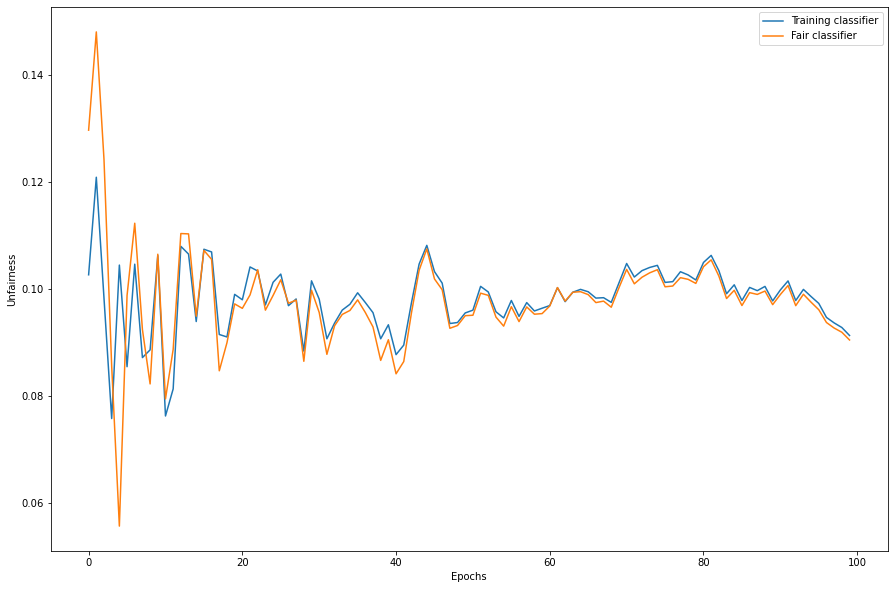

In [13]:
plt.figure(figsize=(15,10))
plt.xlabel('Epochs')
plt.ylabel('Unfairness')
plt.plot(prob_unf_fair,label='Training classifier')
plt.plot(prob_unf_usual,label='Fair classifier')
plt.legend()

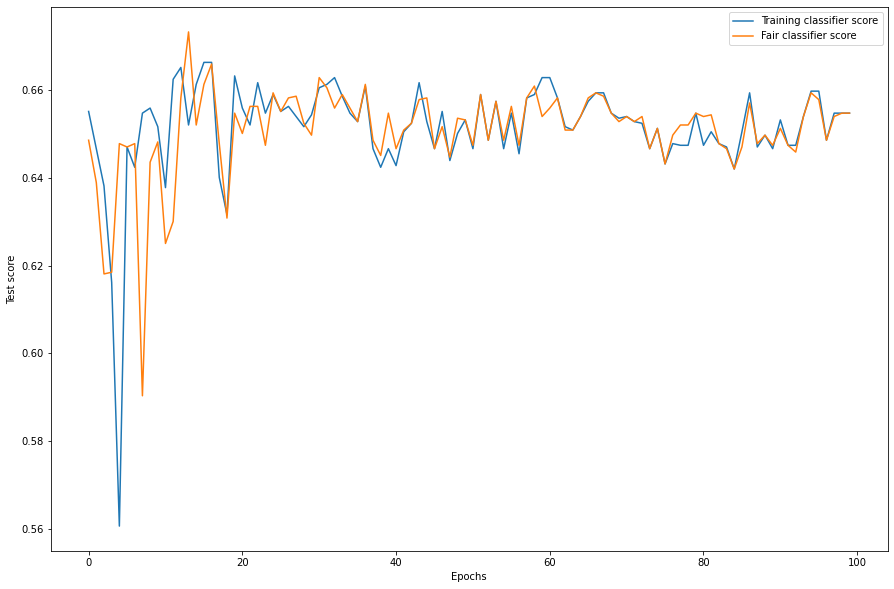

In [15]:
plt.figure(figsize=(15,10))
plt.xlabel('Epochs')
plt.ylabel('Test score')
plt.plot(test_score,label="Training classifier score")
plt.plot(fair_test_score, label="Fair classifier score")
# plt.plot(train_score, label="Train")
plt.legend()